In [ ]:
%pip install plotly

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Note: you may need to restart the kernel to use updated packages.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/JigsawHSI
!pip install spectral

/content/drive/MyDrive/JigsawHSI
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 17.7 MB/s eta 0:00:00


In [3]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral
import time
from tqdm import tqdm, trange
init_notebook_mode(connected=True)
%matplotlib inline

In [4]:
Adam = adam

# Data Loading

In [5]:
## GLOBAL VARIABLES
dataset = 'KSC'
test_ratio = 0.5    
windowSize = 25

In [6]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    elif name == 'KSC':
        data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
        labels = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
    
    return data, labels

In [7]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [8]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [9]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [10]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [11]:
X, y = loadData(dataset)

X.shape, y.shape

((512, 614, 176), (512, 614))

In [12]:
K = X.shape[2]

In [13]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(512, 614, 15)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

In [ ]:
# Path: Hybrid-Spectral-Net.ipynb

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize,K , 1)
Xtrain.shape

(2605, 25, 25, 10, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(2605, 13)

In [ ]:
# Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
# Xvalid.shape

In [ ]:
# yvalid = np_utils.to_categorical(yvalid)
# yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 
if (dataset == 'PU' or dataset == 'PC') :
    output_units = 9
elif dataset == 'IP':
    output_units = 16
elif dataset == "KSC":
    output_units = 13

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

ValueError: Negative dimension size caused by subtracting 5 from 4 for '{{node conv3d_5/Conv3D}} = Conv3D[T=DT_FLOAT, data_format="NDHWC", dilations=[1, 1, 1, 1, 1], padding="VALID", strides=[1, 1, 1, 1, 1]](Placeholder, conv3d_5/Conv3D/ReadVariableOp)' with input shapes: [?,23,23,4,8], [3,3,5,8,16].

In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25, 25, 15, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0     

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

c:\Users\qq163\anaconda3\envs\tfkeras\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning:

The `lr` argument is deprecated, use `learning_rate` instead.



In [ ]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list,validation_split=0.05)

Epoch 1/100
6/6 [==============================] - 7s 197ms/step - loss: 2.4017 - accuracy: 0.1745 - val_loss: 2.1319 - val_accuracy: 0.2658

Epoch 00001: val_accuracy improved from -inf to 0.26582, saving model to best-model.hdf5
Epoch 2/100
6/6 [==============================] - 0s 52ms/step - loss: 2.1087 - accuracy: 0.2965 - val_loss: 1.6776 - val_accuracy: 0.3924

Epoch 00002: val_accuracy improved from 0.26582 to 0.39241, saving model to best-model.hdf5
Epoch 3/100
6/6 [==============================] - 0s 51ms/step - loss: 1.7810 - accuracy: 0.4205 - val_loss: 1.3940 - val_accuracy: 0.5823

Epoch 00003: val_accuracy improved from 0.39241 to 0.58228, saving model to best-model.hdf5
Epoch 4/100
6/6 [==============================] - 0s 50ms/step - loss: 1.4705 - accuracy: 0.5398 - val_loss: 1.1093 - val_accuracy: 0.5949

Epoch 00004: val_accuracy improved from 0.58228 to 0.59494, saving model to best-model.hdf5
Epoch 5/100
6/6 [==============================] - 0s 50ms/step - loss

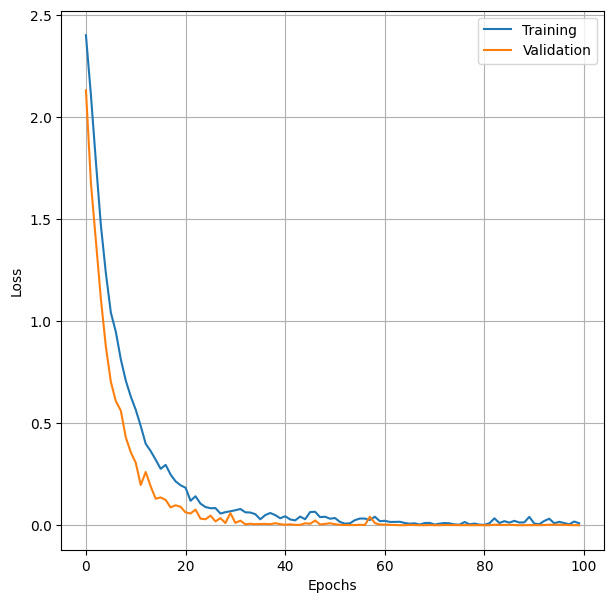

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

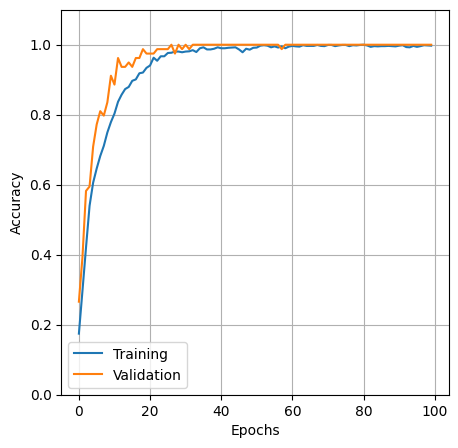

In [ ]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

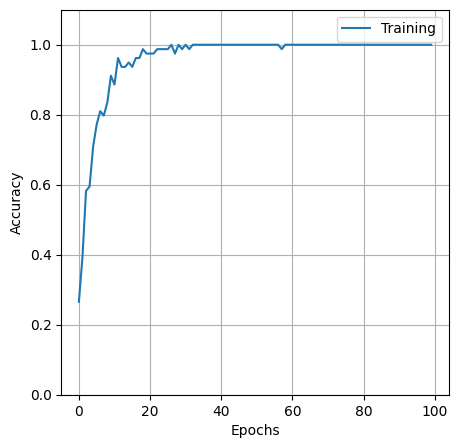

In [ ]:
plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
#plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [ ]:
# load best weights
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(3648, 25, 25, 15, 1)

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(3648, 13)

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       533
           1       0.90      0.98      0.94       170
           2       0.99      0.97      0.98       179
           3       1.00      0.93      0.96       176
           4       0.97      1.00      0.99       113
           5       0.93      0.99      0.96       160
           6       0.97      0.93      0.95        74
           7       1.00      0.95      0.97       302
           8       0.94      0.97      0.96       364
           9       0.98      1.00      0.99       283
          10       1.00      1.00      1.00       293
          11       1.00      0.98      0.99       352
          12       1.00      1.00      1.00       649

    accuracy                           0.98      3648
   macro avg       0.98      0.98      0.98      3648
weighted avg       0.98      0.98      0.98      3648



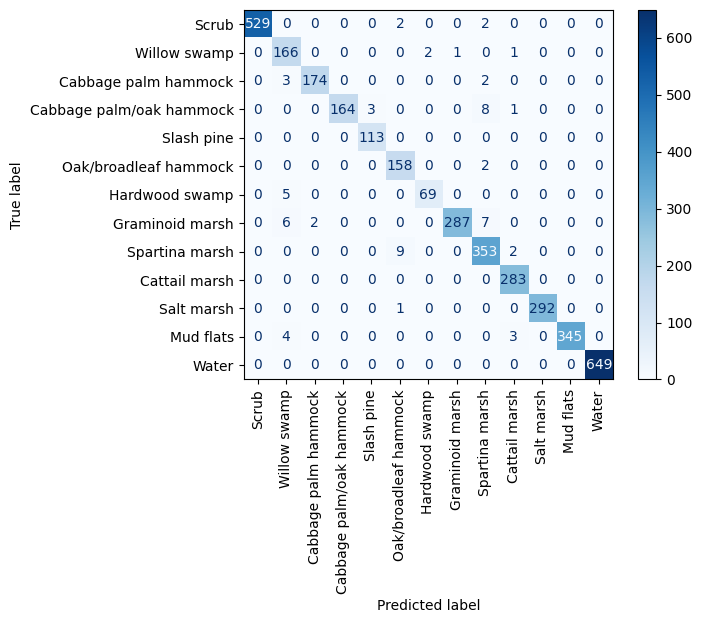

In [ ]:

from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Scrub','Willow swamp','Cabbage palm hammock','Cabbage palm/oak hammock','Slash pine',
                        'Oak/broadleaf hammock','Hardwood swamp','Graminoid marsh','Spartina marsh','Cattail marsh',
                        'Salt marsh','Mud flats','Water'])
disp.plot(cmap=plt.cm.Blues,xticks_rotation='vertical',values_format='d')

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    elif name == 'KSC':
        target_names = ['Scrub','Willow swamp','Cabbage palm hammock','Cabbage palm/oak hammock','Slash pine',
                        'Oak/broadleaf hammock','Hardwood swamp','Graminoid marsh','Spartina marsh','Cattail marsh',
                        'Salt marsh','Mud flats','Water']
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report_KSC30.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

114/114 [==============================] - 0s 3ms/step - loss: 0.0667 - accuracy: 0.9819


In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K
height, width

(512, 614)

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image

outputs = np.zeros((height,width))
for i in trange(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float64')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

100%|██████████| 512/512 [02:31<00:00,  3.37it/s]


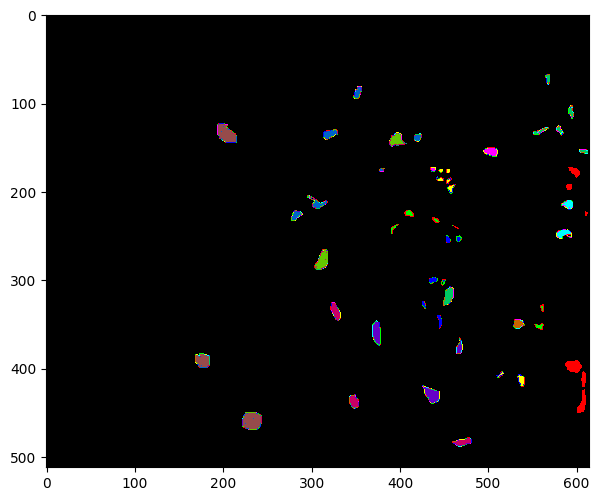

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

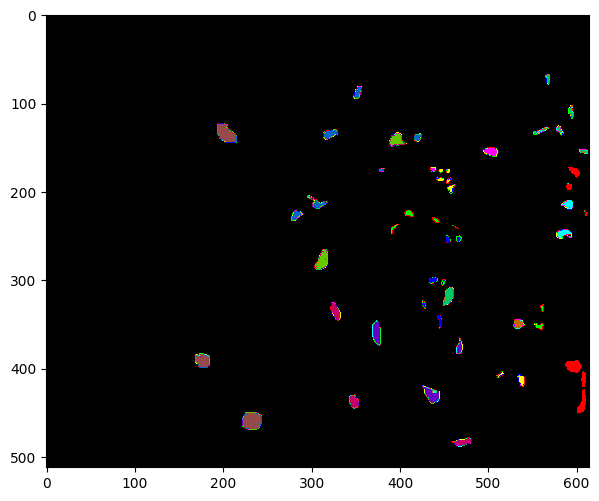

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

ImageView object:
  Interpolation       :  <default>

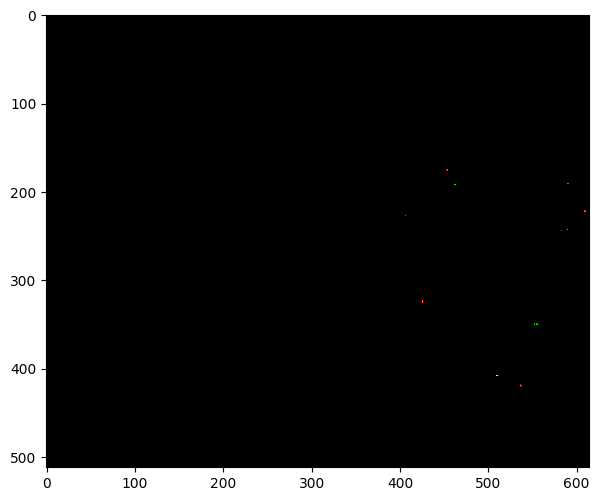

In [ ]:
# 计算两者的差异
spectral.imshow(classes = (outputs.astype(int)-y),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

In [ ]:
# calculate the predicted image ALL
outputs_all = np.zeros((height,width))
for i in trange(height):
    for j in range(width):
        image_patch=Patch(X,i,j)
        X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float64')                                   
        prediction = (model.predict(X_test_image))
        prediction = np.argmax(prediction, axis=1)
        outputs_all[i][j] = prediction+1

100%|██████████| 512/512 [2:34:46<00:00, 18.14s/it]  


ImageView object:
  Interpolation       :  <default>

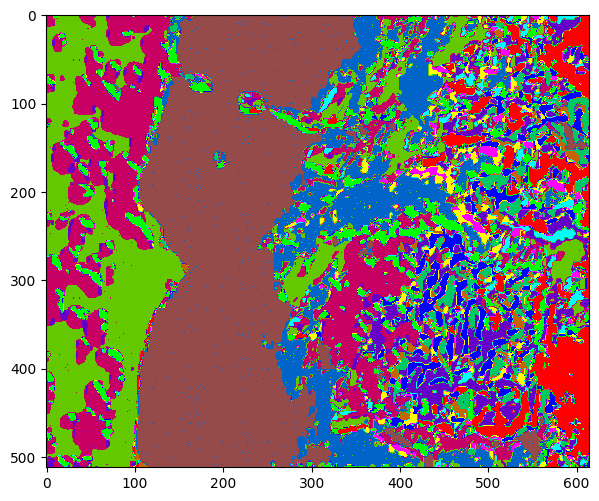

In [ ]:
spectral.imshow(classes = outputs_all.astype(int),figsize =(7,7))

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

In [ ]:
# 计算每一类的准确率

In [ ]:
from matplotlib.colors import ListedColormap, NoNorm

cm = ListedColormap(np.array(spectral.spy_colors)/255.0)
delta = (np.abs(outputs.astype(int) - y)>0)*1
print('Misclassified pixels: ', np.sum(np.asarray(delta)>0), "/", delta.shape[0]*delta.shape[1])
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,8))
ax1.set_title("Ground truth")
ax2.set_title("Prediction")
ax3.set_title("Delta")
ax1.imshow(y) #, cmap=cm, norm=NoNorm())
ax2.imshow(outputs.astype(int)) #, cmap=cm, norm=NoNorm())
ax3.imshow(delta, cmap=cm)
plt.tight_layout()